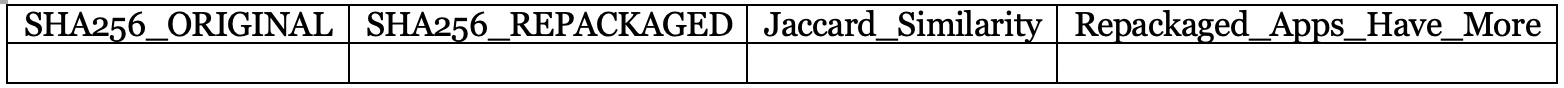

In [35]:
# The csv file you can get from this notebook 

from PIL import Image 

img = Image.open('sample_form-2.png') 
img

In [1]:
import pandas as pd
import numpy as np

In [2]:
int_sensor = {1: 'accelerometer', 35: 'accelerometer_uncalibrated', -1: 'all', 
              13: 'ambient_temperature', 65536: 'device_private_base', 15: 'game_rotation_vector', 
              20: 'geomagnetic_rotation_vector', 9: 'gravity', 4: 'gyroscope', 16: 'gyroscope_uncalibrated', 
              31: 'heart_beat', 21: 'heart_rate', 36: 'hinge_angle', 5: 'light', 10: 'linear_acceleration', 
              34: 'low_latency_offbody_detect', 2: 'magnetic_field', 14: 'magnetic_field_uncalibrated', 
              30: 'motion_detect', 3: 'orientation', 28: 'pose_6dof', 6: 'pressure', 8: 'proximity', 
              12: 'relative_humidity', 11: 'rotation_vector', 17: 'significant_motion', 29: 'stationary_detect', 
              19: 'step_counter', 18: 'step_detector', 7: 'temperature'}

In [3]:
sensor_int = {val: key for key, val in int_sensor.items()}

In [4]:
pairs = pd.read_csv('repackaging_pairs.txt')  # Read the pairs file
pairs = pairs.iloc[3000:6000].reset_index()  # Keep what I need (the first 3000 lines)
pairs=pairs.drop('index',axis=1)
pairs['Jaccard_Similarity'] = 0  # Create a new column used to record Jaccard_Similarity
pairs['Repackaged_Apps_Have_More'] = 0  # Create a new column used to record if the repackaged app uses more sensor than the its original app.
pairs['Difference'] = None  # Create a new column used to record the difference between the sensors used by the original app and the repackaged app.
sensor_usage = pd.read_csv('[3000_6000]Sensor_Usage_v3.csv')  # Read the sensor usage file

In [5]:
cnt_Repackaged_Apps_Have_More = 0  # Used to count how many pairs within which the repackaged app uses more sensor than its original app.
cnt_Original_Apps_Have_More = 0  # Used to count how many pairs within which the original app uses less sensor than the repackaged app.

for i in pairs.index:  # Loop over the pairs
    original = pairs.iloc[i]['SHA256_ORIGINAL']
    repackaged = pairs.iloc[i]['SHA256_REPACKAGE']
    
    # Calculate how many sensors the original app uses
    original_sensor_cnt = np.sum(sensor_usage[sensor_usage['SHA256'] == original].drop(['SHA256', 'Category'], axis = 1).to_numpy())
    # Calculate how many sensors the repackaged app uses
    repackaged_sensor_cnt = np.sum(sensor_usage[sensor_usage['SHA256'] == repackaged].drop(['SHA256', 'Category'], axis = 1).to_numpy())
    # Calculate how many same sensors that both of the original and repackaged apps use.
    sensors_both_have = np.sum(sensor_usage[sensor_usage['SHA256'] == original].drop(['SHA256', 'Category'], axis = 1).to_numpy() * sensor_usage[sensor_usage['SHA256'] == repackaged].drop(['SHA256', 'Category'], axis = 1).to_numpy())
    
    # Calculate the total number of sensors the original and repackaged apps use.
    total_sensors_used = original_sensor_cnt + repackaged_sensor_cnt - sensors_both_have
    
    # Only calculate the Jaccard Similarity for the pairs which using sensors and skip those not using sensors.
    if total_sensors_used > 0:
        jaccard_similarity = sensors_both_have / total_sensors_used
        pairs.loc[i, 'Jaccard_Similarity'] = jaccard_similarity
        pairs.loc[i, 'Repackaged_Apps_Have_More'] = 1 if repackaged_sensor_cnt > original_sensor_cnt else 0
    else:
        pairs.loc[i, 'Jaccard_Similarity'] = None
        pairs.loc[i, 'Repackaged_Apps_Have_More'] = None
    
    original_sensor_usage = sensor_usage[sensor_usage['SHA256'] == original].drop(['SHA256', 'Category'], axis = 1)
    repackaged_sensor_usage = sensor_usage[sensor_usage['SHA256'] == repackaged].drop(['SHA256', 'Category'], axis = 1)
    
    # Find out the difference
    difference = []
    for j in range(original_sensor_usage.shape[1]):
        if (original_sensor_usage.iloc[:, j].to_numpy()[0] == 0 and repackaged_sensor_usage.iloc[:, j].to_numpy()[0] == 1) or (original_sensor_usage.iloc[:, j].to_numpy()[0] == 1 and repackaged_sensor_usage.iloc[:, j].to_numpy()[0] == 0):
            difference.append(sensor_int[original_sensor_usage.columns[j]])
    if difference:
        pairs.at[i, 'Difference'] = pd.Series([difference])
    
    # Count how many pairs within which the repackaged app uses more sensor than its original app.
    cnt_Repackaged_Apps_Have_More += 1 if original_sensor_cnt < repackaged_sensor_cnt else 0
    # Count how many pairs within which the original app uses more sensor than the repackaged app.
    cnt_Original_Apps_Have_More += 1 if original_sensor_cnt > repackaged_sensor_cnt else 0
    
    

In [6]:
pairs_using_sensors = pairs[pairs['Jaccard_Similarity'] >= 0]  # Only keep the pairs which using sensors for now

In [7]:
colindex_2_int={i:sensor_int[c_name] for i,c_name in enumerate(list(sensor_usage.iloc[0:1,2:].columns)) }

In [8]:
def get_sensor_usage_vector(row,colindex_2_int):
    sensor_usage=[colindex_2_int[i]  for i,x in enumerate(row[2:]) if x>0  ]
    return sensor_usage

sensor_usage['sensor_usage']=sensor_usage.apply(lambda x: get_sensor_usage_vector(x,colindex_2_int),axis=1)

In [9]:
sensor_usage_vector_df=sensor_usage[['SHA256','sensor_usage']]
# merge jaccard_similarity files with sensor usage files in order to add two columns
pairs_using_sensors_mody=pairs_using_sensors.merge(sensor_usage_vector_df,how='inner',left_on='SHA256_ORIGINAL',right_on='SHA256')
pairs_using_sensors_mody=pairs_using_sensors_mody.merge(sensor_usage_vector_df,how='inner',left_on='SHA256_REPACKAGE',right_on='SHA256')
## delete useless columns and modify column names
pairs_using_sensors_mody=pairs_using_sensors_mody.drop(['SHA256_x','SHA256_y'],axis=1)
pairs_using_sensors_mody.columns=list(pairs_using_sensors.columns)+['Sensor_Used_ORIGINAL','Sensor_Used_REPACKAGED']


In [10]:
pairs_using_sensors_mody.to_csv('[3000_6000]Jaccard_Similarity_Pairs_Using_Sensors.csv', index = False)

In [11]:
## one way to decode list in csv file
def decode_func(x):
    if x=='[]':
        return []
    else:
        return list(map(int,x.strip('[').strip(']').split(',')))
    
## read list example
pairs_using_sensors_mody=pd.read_csv('[3000_6000]Jaccard_Similarity_Pairs_Using_Sensors.csv',
                                     converters={"Difference": lambda x:decode_func(x),
                                                 "Sensor_Used_ORIGINAL": lambda x:decode_func(x),
                                                 "Sensor_Used_REPACKAGED": lambda x:decode_func(x),
                                                })

## show example
print(pairs_using_sensors_mody.iloc[0]['Sensor_Used_ORIGINAL'])
print(type(pairs_using_sensors_mody.iloc[0]['Sensor_Used_ORIGINAL']))

[]
<class 'list'>
